# Example notebook using a simple positional matching

In [1]:
import numpy
from matplotlib import pylab as plt

In [2]:
from lsst.daf.persistence import Butler
from lsst.afw.image import abMagFromFlux, fluxFromABMag
from lsst.afw.table import MultiMatch
from lsst.meas.astrom import DirectMatchTask

In [3]:
butler = Butler('/home/shared/twinkles/output_data_v2')
subset = butler.subset('src', filter='r')

In [18]:
matched_cat = None
calexps = {}
for data_ref in subset:
    data_id = data_ref.dataId
    src_cat = data_ref.get('src')
    calexps[data_id['visit']] = data_ref.get('calexp')
    if matched_cat is None:
        id_fmt = {'visit':numpy.int64}
        matched_cat = MultiMatch(src_cat.schema, id_fmt)
    matched_cat.add(src_cat, data_id)
final_catalog = matched_cat.finish()

In [127]:
# Experimental cell
for ii, data_red in enumerate(subset):
    print(ii)
subset.__sizeof__()

0
1
2
3
4
5
6
7
8
9


32

In [5]:
object_ids = final_catalog.get('object')
unique_object_ids = set(object_ids)

In [6]:
object_count = {}
avg_flux = {}
stdev_flux = {}
avg_snr = {}
for obj_id in unique_object_ids:
    idx = numpy.where(final_catalog.get('object')==obj_id)[0]
    flux_inst = final_catalog.get('base_PsfFlux_flux')[idx]
    flux_inst_err = final_catalog.get('base_PsfFlux_fluxSigma')[idx]
    flag_gen = final_catalog.get('base_PsfFlux_flag')[idx]
    flag_edge = final_catalog.get('base_PsfFlux_flag_edge')[idx]
    flag_nogood = final_catalog.get('base_PsfFlux_flag_noGoodPixels')[idx]
    visit = final_catalog.get('visit')[idx]
    flux = []
    flux_err = []
    for f, f_err, v, fl1, fl2, fl3 in zip(flux_inst, flux_inst_err, visit, flag_gen, flag_edge, flag_nogood):
        if f > 0. and not (fl1|fl2|fl3):
            calib = calexps[v].getCalib()
            flux.append(fluxFromABMag(calib.getMagnitude(f)))
            flux_err.append(fluxFromABMag(calib.getMagnitude(f_err)))
    flux = numpy.array(flux)
    flux_err = numpy.array(flux_err)
    object_count[obj_id] = len(flux)
    avg_flux[obj_id] = numpy.average(flux)
    stdev_flux[obj_id] = numpy.std(flux)
    avg_snr[obj_id] = sum(flux/flux_err)

/opt/lsst/software/stack/python/miniconda3-4.3.21/lib/python3.6/site-packages/numpy/lib/function_base.py:1128: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/opt/lsst/software/stack/python/miniconda3-4.3.21/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/lsst/software/stack/python/miniconda3-4.3.21/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/opt/lsst/software/stack/python/miniconda3-4.3.21/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/opt/lsst/software/stack/python/miniconda3-4.3.21/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [7]:
matcher = DirectMatchTask(butler=butler)

In [8]:
matches = matcher.run(final_catalog, filterName='r').matches

In [9]:
ref_mags = {}
for match in matches:
    object_id = match.second.get('object')
    ref_mags[object_id] = abMagFromFlux(match.first.get('r_flux'))

In [10]:
mags = []
g_flux = []
g_flux_std = []
g_snr = []
ids = []
for obj_id in unique_object_ids:
    if object_count[obj_id] > 8:
        g_flux.append(avg_flux[obj_id])
        g_flux_std.append(stdev_flux[obj_id])
        g_snr.append(avg_snr[obj_id])
        mags.append(abMagFromFlux(avg_flux[obj_id]))
        ids.append(obj_id)
g_flux = numpy.array(g_flux)
g_flux_std = numpy.array(g_flux_std)

(0.98, 1.02)

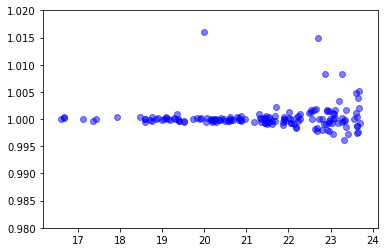

In [11]:
for i, m in zip(ids, mags):
    if i in ref_mags:
        plt.scatter(m, ref_mags[i]/m, color='b', alpha=0.5)
plt.ylim(0.98, 1.02) # there is one significant outlier

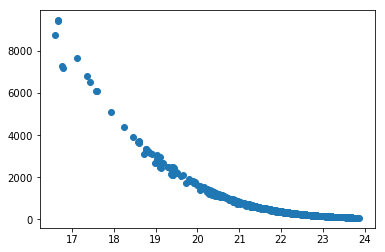

In [12]:
plt.scatter(mags, g_snr)

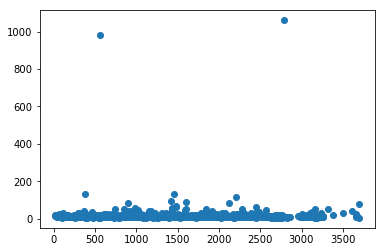

In [13]:
plt.scatter(ids, g_snr/(g_flux/g_flux_std))

In [14]:
idx = numpy.where(g_snr/(g_flux/g_flux_std) > 800)[0]

In [15]:
outlier_ids = [ids[el] for el in idx]

In [16]:
outlier1_idx = numpy.where(final_catalog.get('object')==outlier_ids[0])[0]
outlier2_idx = numpy.where(final_catalog.get('object')==outlier_ids[1])[0]

In [17]:
len(final_catalog)

19962